In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Retriever 및 Chain 

In [8]:
from pdf_retriever_saju import pdf_rag_chain, compression_retriever

pdf_retriever = compression_retriever()
pdf_chain = pdf_rag_chain()

In [9]:
# Manse_tool

In [10]:
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing import Optional

class SajuInfo(BaseModel):
    """사주 계산에 필요한 정보를 추출하는 스키마"""
    year: int = Field(description="생년 (예: 1995)")
    month: int = Field(description="월 (1-12)")
    day: int = Field(description="일 (1-31)")
    hour: int = Field(description="시간 (0-23)", default=12)
    minute: int = Field(description="분 (0-59)", default=0)
    is_male: bool = Field(description="남성 여부 (남자: True, 여자: False)")
    timezone: str = Field(description="시간대", default="Asia/Seoul")

def extract_user_info_structured(question: str) -> dict:
    """structured output을 사용해서 사주 정보 추출"""
    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    
    # structured output 설정
    structured_llm = llm.with_structured_output(SajuInfo)
    
    prompt = f"""
    다음 문장에서 생년월일, 시간, 성별을 추출해서 사주 정보로 변환해주세요.
    시간이 명시되지 않으면 12시로, 분이 명시되지 않으면 0분으로 기본값을 사용하세요.
    
    문장: "{question}"
    """
    
    try:
        saju_info = structured_llm.invoke(prompt)
        return saju_info.model_dump()
    except Exception as e:
        print("구조화된 추출 실패:", e)
        return None

In [11]:
from manse_tool import calculate_saju_tool

def main_structured(question: str):
    """structured output을 사용한 사주 분석 파이프라인"""
    user_info = extract_user_info_structured(question)
    if user_info is None:
        print("입력에서 정보를 추출할 수 없습니다.")
        return
    
    print("추출된 정보:", user_info)
    result = calculate_saju_tool.invoke(user_info)
    print("\n=== 사주 분석 결과 ===")
    print(result)

# 테스트
main_structured("1995년 3월 28일 12시 30분 출생")


추출된 정보: {'year': 1995, 'month': 3, 'day': 28, 'hour': 12, 'minute': 30, 'is_male': True, 'timezone': 'Asia/Seoul'}

=== 사주 분석 결과 ===
=== 사주팔자 ===
년주(年柱): 을해
월주(月柱): 기묘
일주(日柱): 무오
시주(時柱): 무오
일간(日干): 무

=== 오행 강약 ===
목: 39점
화: 20점
토: 68점
금: 0점
수: 10점

=== 십신 분석 ===
년주: 천간:정관, 지지:편재(70%), 지지:편관(30%)
월주: 천간:겁재, 지지:정관(100%)
일주: 지지:정인(70%), 지지:겁재(30%)
시주: 지지:정인(70%), 지지:겁재(30%)

=== 대운 (정밀 계산) ===
5세: 무인 (2000년 ~ 2009년)
15세: 정축 (2010년 ~ 2019년)
25세: 병자 (2020년 ~ 2029년)
35세: 을해 (2030년 ~ 2039년)


In [12]:
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate

# PDF 문서를 기반으로 검색 도구 생성
retriever_tool = create_retriever_tool(
    pdf_retriever,
    "pdf_retriever",
    "A tool for searching information related to Saju (Four Pillars of Destiny)",
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
    ),
)


In [15]:
tools = [retriever_tool]

In [14]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


# 에이전트 상태를 정의하는 타입 딕셔너리, 메시지 시퀀스를 관리하고 추가 동작 정의
class AgentState(TypedDict):
    # add_messages reducer 함수를 사용하여 메시지 시퀀스를 관리
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [17]:
from typing import Literal
from langchain import hub
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition
from langchain_teddynote.models import get_model_name, LLMs

# 최신 모델이름 가져오기
# MODEL_NAME = get_model_name(LLMs.GPT4)


# 데이터 모델 정의
class grade(BaseModel):
    """A binary score for relevance checks"""

    binary_score: str = Field(
        description="Response 'yes' if the document is relevant to the question or 'no' if it is not."
    )


def grade_documents(state) -> Literal["generate", "rewrite"]:
    # LLM 모델 초기화
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)

    # 구조화된 출력을 위한 LLM 설정
    llm_with_tool = model.with_structured_output(grade)

    # 프롬프트 템플릿 정의
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # llm + tool 바인딩 체인 생성
    chain = prompt | llm_with_tool

    # 현재 상태에서 메시지 추출
    messages = state["messages"]

    # 가장 마지막 메시지 추출
    last_message = messages[-1]

    # 원래 질문 추출
    question = messages[0].content

    # 검색된 문서 추출
    retrieved_docs = last_message.content

    # 관련성 평가 실행
    scored_result = chain.invoke({"question": question, "context": retrieved_docs})

    # 관련성 여부 추출
    score = scored_result.binary_score

    # 관련성 여부에 따른 결정
    if score == "yes":
        print("==== [DECISION: DOCS RELEVANT] ====")
        return "generate"

    else:
        print("==== [DECISION: DOCS NOT RELEVANT] ====")
        print(score)
        return "rewrite"


def agent(state):
    # 현재 상태에서 메시지 추출
    messages = state["messages"]

    # LLM 모델 초기화
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")

    # retriever tool 바인딩
    model = model.bind_tools(tools)

    # 에이전트 응답 생성
    response = model.invoke(messages)

    # 기존 리스트에 추가되므로 리스트 형태로 반환
    return {"messages": [response]}


def rewrite(state):
    print("==== [QUERY REWRITE] ====")
    # 현재 상태에서 메시지 추출
    messages = state["messages"]
    # 원래 질문 추출
    question = messages[0].content

    # 질문 개선을 위한 프롬프트 구성
    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # LLM 모델로 질문 개선
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    # Query-Transform 체인 실행
    response = model.invoke(msg)

    # 재작성된 질문 반환
    return {"messages": [response]}

from langchain_core.prompts import load_prompt

def generate(state):
    # 현재 상태에서 메시지 추출
    messages = state["messages"]

    # 원래 질문 추출
    question = messages[0].content

    # 가장 마지막 메시지 추출
    docs = messages[-1].content

    # RAG 프롬프트 템플릿 가져오기
    prompt = load_prompt("prompt/saju-rag-prompt_korea.yaml")

    # LLM 모델 초기화
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    # RAG 체인 구성
    rag_chain = prompt | llm | StrOutputParser()

    # 답변 생성 실행
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [18]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

# AgentState 기반 상태 그래프 워크플로우 초기화
workflow = StateGraph(AgentState)

# 노드 정의
workflow.add_node("agent", agent)  # 에이전트 노드
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # 검색 노드
workflow.add_node("rewrite", rewrite)  # 질문 재작성 노드
workflow.add_node("generate", generate)  # 관련 문서 확인 후 응답 생성 노드

# 엣지 연결
workflow.add_edge(START, "agent")

# 검색 여부 결정을 위한 조건부 엣지 추가
workflow.add_conditional_edges(
    "agent",
    # 에이전트 결정 평가
    tools_condition,
    {
        # 조건 출력을 그래프 노드에 매핑
        "tools": "retrieve",
        END: END,
    },
)

# 액션 노드 실행 후 처리될 엣지 정의
workflow.add_conditional_edges(
    "retrieve",
    # 문서 품질 평가
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# 그래프 컴파일
graph = workflow.compile(checkpointer=MemorySaver())

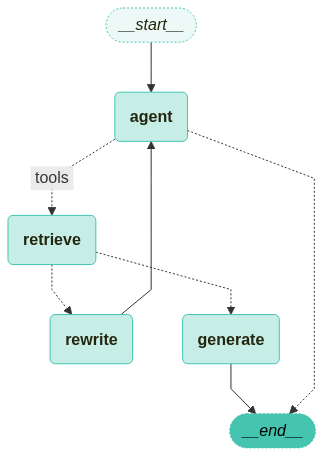

In [19]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [21]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "사주의 불에 대해서 설명해줘"),
    ]
}

# 그래프 실행
invoke_graph(graph, inputs, config)


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  pdf_retriever (call_v1h6whGbjr1GKCaUtHp72YJD)
 Call ID: call_v1h6whGbjr1GKCaUtHp72YJD
  Args:
    query: 사주 불
==== [DECISION: DOCS NOT RELEVANT] ====
no

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: pdf_retriever

Error: ValueError("Document prompt requires documents to have metadata variables: ['page', 'source']. Received document with missing metadata: ['page'].\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT ")
 Please fix your mistakes.
==== [QUERY REWRITE] ====

🔄 Node: rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

To improve the question for clarity and dep

GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT